## Imports e Definições Globais

Abaixo as definições globais que serão utilizadas ao longo de todo o notebook.

In [6]:
import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

OUT_CSV = "./embeddings.csv"
MAX_WORKERS = 8
RANDOM_STATE = 42
TRUSTWORTHINESS_N_NEIGHBORS = 10

# Detecta GPU MPS (Apple Silicon)
device = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"🎛 Device: {device}")

🎛 Device: mps


## Carregando Embeddings

In [7]:
import ast

print("⏳ Localizando arquivo CSV em:", OUT_CSV)

csv_exists = os.path.isfile(OUT_CSV)

if csv_exists:
    print("📄 Arquivo CSV encontrado. Carregando embeddings existentes...\n")
    df = pd.read_csv(OUT_CSV)

    # converter string → lista
    df["embedding"] = df["embedding"].apply(ast.literal_eval)

else:
    raise FileNotFoundError(
        f"Nenhum arquivo CSV existente em {OUT_CSV}. Execute o pipeline de geração de embeddings primeiro."
    )

print("\n📊 Shape do DataFrame:", df.shape)

valid_vectors = df[df["error"].isna()]["embedding"]

if len(valid_vectors) > 0:
    print("📏 Dimensão do primeiro embedding válido:", len(valid_vectors.iloc[0]))
else:
    print("⚠ Nenhum embedding válido encontrado.")

print("\n✅ Processamento concluído!")


⏳ Localizando arquivo CSV em: ./embeddings.csv
📄 Arquivo CSV encontrado. Carregando embeddings existentes...


📊 Shape do DataFrame: (1734, 4)
📏 Dimensão do primeiro embedding válido: 384

✅ Processamento concluído!


Visualização preliminar básica da estrutura gerada.

In [8]:
import numpy as np

# Filtra apenas os embeddings válidos
valid_df = df[df["error"].isna()].reset_index(drop=True)

# Converte lista de listas -> matriz numpy
sentence_embeddings = np.vstack(valid_df["embedding"].values)

print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")
print(f"Primeiros 10 valores do primeiro embedding:\n{sentence_embeddings[0][:10]}...")


Shape da matriz de embeddings: (1734, 384)
Primeiros 10 valores do primeiro embedding:
[-0.05767569  0.04167436 -0.08998812 -0.04664695  0.02898168 -0.01683943
 -0.05458979  0.06848723 -0.02440902  0.00618731]...


## PCA

### Aplicando o PCA com 2 dimensões

O trecho a seguir reduz a dimensionalidade dos embeddings de 384 para 2 dimensões, calcula trustworthiness e gera um gráfico da projeção 2D.

Shape após PCA: (1734, 2)
Trustworthiness (PCA): 0.789371


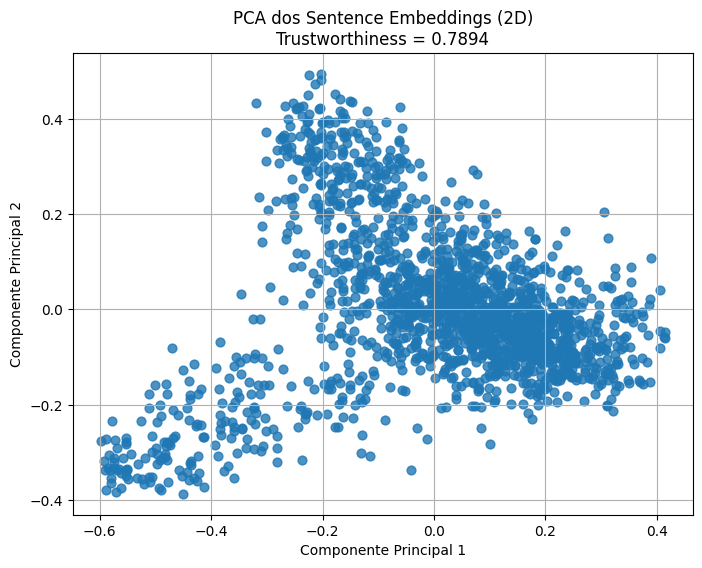

In [9]:
# ============================================================
# PCA — Redução para 2D com Trustworthiness (configuração única)
# ============================================================

from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) PCA: projeção para 2 dimensões (não altera sentence_embeddings)
# ------------------------------------------------------------
pca_2d_model = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d_result = pca_2d_model.fit_transform(sentence_embeddings)

print("Shape após PCA:", X_pca_2d_result.shape)

# ------------------------------------------------------------
# 2) Trustworthiness (métrica padronizada entre métodos)
# ------------------------------------------------------------
trust_pca_2d_result = trustworthiness(
    sentence_embeddings,
    X_pca_2d_result,
    n_neighbors=TRUSTWORTHINESS_N_NEIGHBORS
)

print(f"Trustworthiness (PCA): {trust_pca_2d_result:.6f}")

# ------------------------------------------------------------
# 3) Scatter plot (visualização simples)
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d_result[:, 0], X_pca_2d_result[:, 1], s=40, alpha=0.8)

plt.title(f"PCA dos Sentence Embeddings (2D)\nTrustworthiness = {trust_pca_2d_result:.4f}")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()


### Aplicando o PCA com 3 dimensões

O trecho a seguir reduz a dimensionalidade dos embeddings de 384 para 3 dimensões, calcula trustworthiness e gera um gráfico da projeção 3D rotacionável.

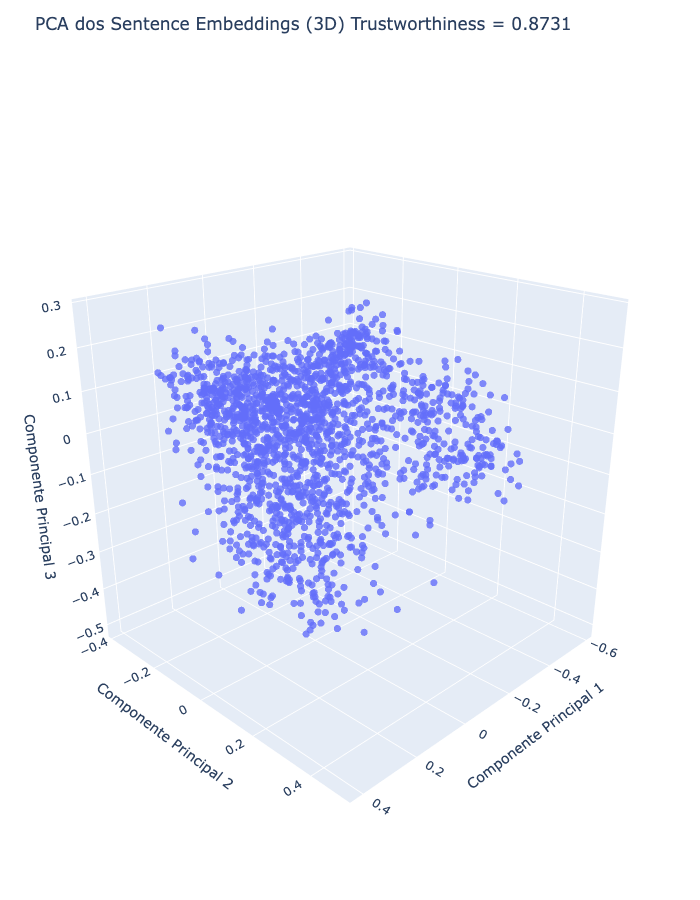

In [10]:
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness

# ------------------------------------------------------------
# PCA 3D
# ------------------------------------------------------------
pca_3d_model = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d_result = pca_3d_model.fit_transform(sentence_embeddings)

trust_pca_3d_result = trustworthiness(
    sentence_embeddings, 
    X_pca_3d_result, 
    n_neighbors=TRUSTWORTHINESS_N_NEIGHBORS
)

fig = px.scatter_3d(
    x=X_pca_3d_result[:, 0],
    y=X_pca_3d_result[:, 1],
    z=X_pca_3d_result[:, 2],
    title=f"PCA dos Sentence Embeddings (3D)\nTrustworthiness = {trust_pca_3d_result:.4f}",
)

fig.update_traces(marker=dict(size=4, opacity=0.8))

fig.update_layout(
    scene=dict(
        xaxis_title="Componente Principal 1",
        yaxis_title="Componente Principal 2",
        zaxis_title="Componente Principal 3",
        aspectmode="cube"
    ),
    scene_camera=dict(eye=dict(x=1.8, y=1.8, z=1.1)),  # corrige o “corte”
    margin=dict(l=0, r=0, b=0, t=60),
    height=900
)


fig.show()
fig.write_image("pca3d.png")

display(Image("pca3d.png"))


Após a projeção dos embeddings em duas e três dimensões por PCA, não se observam a formação de agrupamentos claros. Isso também é evidenciado pela métrica de trustworthiness relativamente baixa em ambos os casos. Muito embora a redução para 3 dimensões gerou uma métrica melhor, ainda assim ela é relativamente muito mais baixa do que as métricas dos métodos que serão vistos posteriormente. Isso sugere a existencia de relações não lineares mais fortes que as lineares nos dados analisados.

### Clustering
Apesar dos dados preliminares de PCA indicarem que muito provavelmente utilizar um modelo essencialmente linear sobre nossos dados não seja muito recomendável, vamos aplicar o DBSCAN para tentar identificar a existência de clusters e visualmente observar se os agrupamentos que se formam sugerem alguma consistência na aplicação do método. Entretanto, não vamos aplicar nenhum tipo de GridSearch pois acreditamos que os dados preliminares sugerem que não devemos explorar muito a hipotese linear.

Trustworthiness PCA: 0.7893713469573764


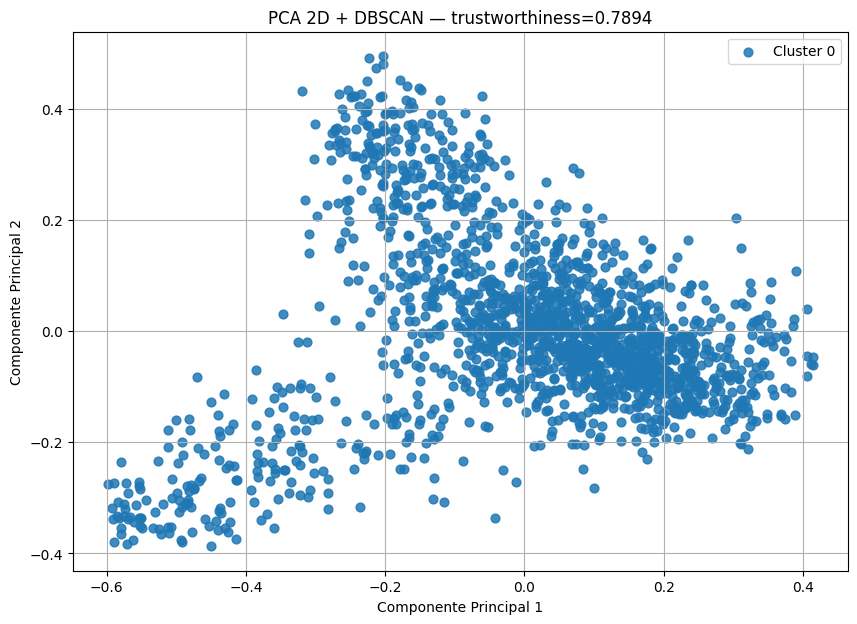

In [11]:
# ============================================================
# PCA — redução para 2D (versão final padronizada)
# ============================================================

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# DBSCAN para PCA (melhor achado)
# ---------------------------

dbscan_pca_2d = DBSCAN(eps=0.08, min_samples=4)
labels_pca_2d = dbscan_pca_2d.fit_predict(X_pca_2d_result)  # nome padronizado

# ---------------------------
# Trustworthiness do PCA
# ---------------------------

trustworthiness_pca_2d = trustworthiness(
    sentence_embeddings,   # espaço original
    X_pca_2d_result,            # projeção PCA 2D
    n_neighbors=TRUSTWORTHINESS_N_NEIGHBORS
)

print("Trustworthiness PCA:", trustworthiness_pca_2d)

# ---------------------------
# Plot PCA + DBSCAN
# ---------------------------

unique_labels_pca_2d = sorted(set(labels_pca_2d))
colors_pca_2d = plt.cm.tab10(np.linspace(0, 1, len(unique_labels_pca_2d)))

plt.figure(figsize=(10, 7))

for lab, col in zip(unique_labels_pca_2d, colors_pca_2d):
    mask = labels_pca_2d == lab
    nome = "Ruído" if lab == -1 else f"Cluster {lab}"
    plt.scatter(
        X_pca_2d_result[mask, 0],
        X_pca_2d_result[mask, 1],
        s=40,
        color=col,
        alpha=0.35 if lab == -1 else 0.85,
        label=nome
    )

plt.title(f"PCA 2D + DBSCAN — trustworthiness={trustworthiness_pca_2d:.4f}")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# ============================================================
# PCA — redução para 3D
# ============================================================

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# DBSCAN para PCA (melhor achado)
# ---------------------------

dbscan_pca_3d = DBSCAN(eps=0.08, min_samples=4)
labels_pca_3d = dbscan_pca_3d.fit_predict(X_pca_3d_result)  # nome padronizado

# ---------------------------
# Trustworthiness do PCA
# ---------------------------

trustworthiness_pca_3d = trustworthiness(
    sentence_embeddings,   # espaço original
    X_pca_3d_result,            # projeção PCA 3D
    n_neighbors=TRUSTWORTHINESS_N_NEIGHBORS
)

print("Trustworthiness PCA:", trustworthiness_pca_3d)


Trustworthiness PCA: 0.8730584362653652


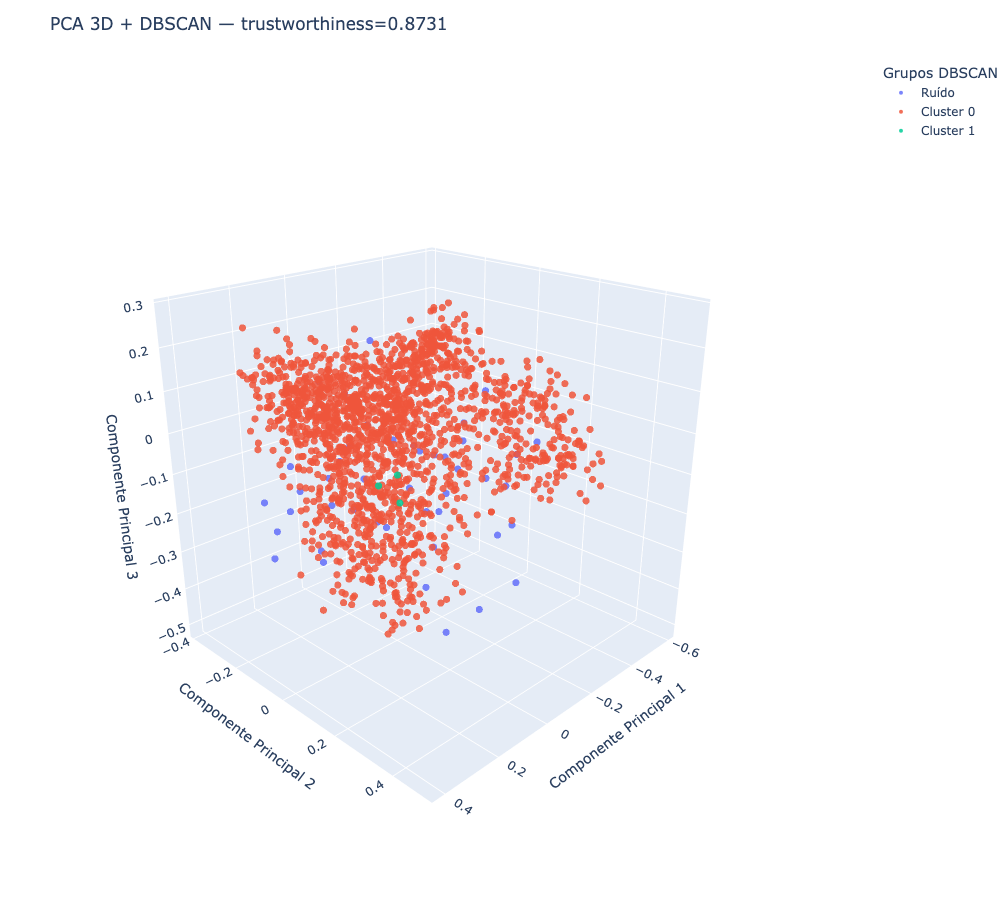

In [13]:
import plotly.express as px
import numpy as np

# ---------------------------
# Nomear clusters
# ---------------------------
def nome_cluster(lab):
    return "Ruído" if lab == -1 else f"Cluster {lab}"

cluster_names = np.array([nome_cluster(l) for l in labels_pca_3d])

# ---------------------------
# Ordem da legenda: Ruído → Cluster 0 → Cluster 1…
# ---------------------------
unique_names_ordered = sorted(set(cluster_names), key=lambda x: (x != "Ruído", x))

# ---------------------------
# Plot 3D com cores DEFAULT do Plotly
# ---------------------------
fig = px.scatter_3d(
    x=X_pca_3d_result[:, 0],
    y=X_pca_3d_result[:, 1],
    z=X_pca_3d_result[:, 2],
    color=cluster_names,                # ← cluster names definem as cores default
    category_orders={"color": unique_names_ordered},  # ← ordenação correta da legenda
    title=f"PCA 3D + DBSCAN — trustworthiness={trustworthiness_pca_3d:.4f}",
)

fig.update_traces(marker=dict(size=4, opacity=0.85))

fig.update_layout(
    legend_title_text="Grupos DBSCAN",
    scene=dict(
        xaxis_title="Componente Principal 1",
        yaxis_title="Componente Principal 2",
        zaxis_title="Componente Principal 3",
        aspectmode="cube",
    ),
    scene_camera=dict(eye=dict(x=1.8, y=1.8, z=1.1)),
    margin=dict(l=0, r=0, b=0, t=60),
    width=1000,
    height=900
)

fig.show()

# ----------------------------------------------
# Salvar imagem estática sem alterar cores
# ----------------------------------------------
fig.write_image("pca3d_dbscan.png")
display(Image("pca3d_dbscan.png"))


Como se pode observar, o DBSCAN aplicado tanto sobre PCA 2D quanto PCA 3D gerou resultados pobres, o que reforça os indicadores numéricos vistos anteriormente.